# Bitcoin Fear & Greed Index Analysis

This notebook analyzes the relationship between the Bitcoin Fear & Greed Index and Bitcoin price movements.

## Google Colab Setup
This notebook is configured to run in Google Colab. Follow the steps below to set up your environment.

In [3]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Install Required Packages

Run the cell below to install the necessary packages:

In [4]:
# Install required packages
!pip install yfinance pandas numpy matplotlib scipy scikit-learn statsmodels

In [5]:
try:
   import yfinance as yf
except Exception:
  yf = None


from scipy import stats

CONFIG / HYPERPARAMETERS

In [6]:
START_DATE = '2015-01-01'
END_DATE = None
TX_COST_BPS = 10
RISK_FREE = 0.0
MAX_PLOTS = True
PRICE_TICKER = 'BTC-USD'
LOCAL_PRICE_CSV = None

LOAD SENTIMENT DATA

# Upload Fear & Greed Index Data

Upload the `fear_greed_index.csv` file from your local machine:

In [1]:
# Load the fear and greed index CSV file from local path
import os

# Define the path to the CSV file
fear_greed_csv_path = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'csv_files', 'fear_greed_index.csv')

# Verify the file exists
print(f"Looking for file at: {fear_greed_csv_path}")
print(f"File exists: {os.path.exists(fear_greed_csv_path)}")

Looking for file at: c:\Users\Khush\OneDrive\Documents\ds_khushbooKumari\csv_files\fear_greed_index.csv
File exists: True


In [7]:
sent = pd.read_csv(fear_greed_csv_path)
sent.columns = [c.strip().title() for c in sent.columns]
if 'Date' not in sent.columns or 'Classification' not in sent.columns:
   raise ValueError("fear_greed_index.csv must contain 'Date' and 'Classification' columns.")


sent['Date'] = pd.to_datetime(sent['Date'], errors='coerce').dt.tz_localize(None)
sent = sent.dropna(subset=['Date']).sort_values('Date').reset_index(drop=True)


# Display the first few rows to confirm the data loaded correctly
print("First 5 rows of the fear & greed index data:")
display(sent.head())

First 5 rows of the fear & greed index data:


,Timestamp,Value,Classification,Date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


Normalize labels

In [8]:
sent['Classification'] = sent['Classification'].str.strip().str.title()
# Map to numeric score (0=Fear, 1=Greed). Unrecognized labels become NaN
label_map = {'Fear': 0, 'Greed': 1}
sent['SentimentScore'] = sent['Classification'].map(label_map)


# If there is also a numeric index column (sometimes provided), try to use it
for candidate in ['Value', 'Index', 'Score', 'Fgi', 'FearGreedIndex']:
  if candidate in sent.columns and pd.api.types.is_numeric_dtype(sent[candidate]):
      sent['SentimentIndex'] = pd.to_numeric(sent[candidate], errors='coerce')
      break
  else:
# fallback: scale binary score so we still have a numeric index (0/100)
   sent['SentimentIndex'] = sent['SentimentScore'] * 100

LOAD BTC PRICES

In [9]:
# Load Bitcoin price data either from a local CSV or yfinance
if LOCAL_PRICE_CSV and os.path.exists(LOCAL_PRICE_CSV):
   px = pd.read_csv(LOCAL_PRICE_CSV)
   px['Date'] = pd.to_datetime(px['Date'], errors='coerce').dt.tz_localize(None)
   if 'Close' not in px.columns:
      raise ValueError("Local price CSV must have columns: Date, Close")
   px = px[['Date','Close']].dropna().sort_values('Date').reset_index(drop=True)
else:
   print("Downloading price data from yfinance...")
   data = yf.download(PRICE_TICKER, start=START_DATE, end=END_DATE)
   
   # If MultiIndex, flatten it
   if isinstance(data.columns, pd.MultiIndex):
       data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data.columns]
   
   # Find the close column 
   close_col = [c for c in data.columns if "Close" in c][0]
   
   # Build px dataframe
   px = data.reset_index()[['Date', close_col]].rename(columns={close_col: 'Close'})
   px['Date'] = pd.to_datetime(px['Date'], errors='coerce').dt.tz_localize(None)
   px = px.dropna().sort_values('Date').reset_index(drop=True)
   print(f"Downloaded {len(px)} days of price data")

C:\Users\Khush\AppData\Local\Temp\ipykernel_18036\2763006813.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(PRICE_TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed

Downloaded 3885 days of price data


Compute returns

In [10]:
px = px.dropna().sort_values('Date').reset_index(drop=True)
px['Ret'] = px['Close'].pct_change()

In [11]:
# Display information about the loaded price data
print("Price data summary:")
print(f"Date range: {px['Date'].min()} to {px['Date'].max()}")
print(f"Total days: {len(px)}")
print(f"Latest BTC price: ${px['Close'].iloc[-1]:.2f}")
print(f"Available columns: {px.columns.tolist()}")

# Verify returns are calculated
if 'Ret' not in px.columns:
    px['Ret'] = px['Close'].pct_change()
    
print(f"\nFirst 5 rows with returns:")
display(px.head())

Price data summary:
Date range: 2015-01-01 00:00:00 to 2025-08-20 00:00:00
Total days: 3885
Latest BTC price: $113614.20
Available columns: ['Date', 'Close', 'Ret']

First 5 rows with returns:


,Date,Close,Ret
0,2015-01-01,314.248993,NaN
1,2015-01-02,315.032013,0.002492
2,2015-01-03,281.082001,-0.107767
3,2015-01-04,264.195007,-0.060079
4,2015-01-05,274.473999,0.038907


MERGE & FEATURE ENGINEERING

In [12]:
df = pd.merge_asof(sent.sort_values('Date'), px.sort_values('Date'), on='Date')
# Forward-fill price rows missing due to non-overlapping calendars
# (merge_asof aligns to nearest previous price date). Ensure returns computed later use price df directly.


# Lag sentiment to avoid look-ahead bias: use yesterday's sentiment to trade today
for lag in [0, 1, 2, 3, 5, 7]:
  df[f'SentimentIndex_lag{lag}'] = df['SentimentIndex'].shift(lag)
  df[f'SentimentScore_lag{lag}'] = df['SentimentScore'].shift(lag)


# Rolling z-score of the numeric index (using lag1 to avoid peek)
roll = 14
df['SentIndex_lag1_znorm'] = (df['SentimentIndex_lag1'] - df['SentimentIndex_lag1'].rolling(90).mean()) \
                               / df['SentimentIndex_lag1'].rolling(90).std()


# Label market up/down using next-day return (for supervised tasks)
df['Ret_next'] = df['Ret'].shift(-1)
df['UpNext'] = (df['Ret_next'] > 0).astype(int)

4) SIGNALS (TRADER BEHAVIOURS)

In [13]:
# Strategy A: Follower (Risk-on when Greed)
# - If yesterday's sentiment is Greed (>=50), go long; else go flat.


df['A_pos'] = (df['SentimentIndex_lag1'] >= 50).astype(int)


# Strategy B: Contrarian (Buy Fear)
# - If yesterday's sentiment <= 50 (Fear), go long; else flat.


df['B_pos'] = (df['SentimentIndex_lag1'] <= 50).astype(int)


# Strategy C: Extremes Mean-Reversion
# - Long only when extreme fear (z < -1), flat otherwise


df['C_pos'] = (df['SentIndex_lag1_znorm'] < -1.0).astype(int)


# Buy & Hold benchmark
px['BH_ret'] = px['Ret']


# Align positions to price returns calendar
# Align positions to price returns calendar
pos = df[['Date','A_pos','B_pos','C_pos']].dropna()
perf = pd.merge_asof(px[['Date','Ret']], pos, on='Date').fillna(0)

# Buy & Hold strategy (always long)
perf['BH_ret'] = perf['Ret']

# Transaction costs for strategies
for col in ['A_pos','B_pos','C_pos']:
    # Strategy return = position(t-1) * ret(t)
    perf[f'{col}_ret_gross'] = perf[col].shift(1) * perf['Ret']
    # Turnover = position change
    perf[f'{col}_turnover'] = (perf[col].shift(1).fillna(0) - perf[col]).abs()
    # Apply cost
    tc = (TX_COST_BPS/10000.0) * perf[f'{col}_turnover']
    perf[f'{col}_ret_net'] = perf[f'{col}_ret_gross'] - tc

# Buy & Hold has no turnover cost
perf['BH_ret_net'] = perf['BH_ret']


5) PERFORMANCE METRICS

In [14]:

def perf_stats(returns, freq=365, name='strategy'):
    r = returns.dropna()
    if len(r) == 0:
        return {'name': name, 'CAGR': np.nan, 'Vol': np.nan, 'Sharpe': np.nan,
                'MaxDD': np.nan, 'HitRate': np.nan, 'AvgWin': np.nan, 'AvgLoss': np.nan}
    # CAGR
    cum = (1 + r).prod()
    years = max((r.index[-1] - r.index[0]).days, 1) / 365.25
    cagr = cum ** (1 / years) - 1 if years > 0 else np.nan
    # Vol & Sharpe
    vol = r.std() * np.sqrt(freq)
    sharpe = (r.mean() * freq - RISK_FREE * freq) / (r.std() * np.sqrt(freq)) if r.std() > 0 else np.nan
    # Max Drawdown
    eq = (1 + r).cumprod()
    dd = (eq / eq.cummax() - 1).min()
    # Hit Rate / Avg win-loss
    wins, losses = r[r > 0], r[r <= 0]
    hit = len(wins) / len(r) if len(r) else np.nan
    return {'name': name, 'CAGR': cagr, 'Vol': vol, 'Sharpe': sharpe,
            'MaxDD': dd, 'HitRate': hit,
            'AvgWin': wins.mean() if len(wins) else np.nan,
            'AvgLoss': losses.mean() if len(losses) else np.nan}

# Build summary table
perf = perf.dropna().copy()
perf.index = pd.to_datetime(perf['Date'])

rows = [perf_stats(perf['BH_ret_net'], name='Buy&Hold')]
for col in ['A_pos', 'B_pos', 'C_pos']:
    rows.append(perf_stats(perf[f'{col}_ret_net'], name=col.replace('_pos', '')))
stats_df = pd.DataFrame(rows)

print("==== Performance Summary ====")
print(stats_df)
stats_df.to_csv('strategy_performance_summary.csv', index=False)


==== Performance Summary ====
       name      CAGR       Vol    Sharpe     MaxDD   HitRate    AvgWin  \
0  Buy&Hold  0.740325  0.680465  1.157016 -0.833990  0.528836  0.024120   
1         A  0.240714  0.351531  0.787400 -0.492290  0.171988  0.023449   
2         B -0.017254  0.422003  0.174955 -0.762276  0.199279  0.023330   
3         C  0.029609  0.284296  0.251289 -0.552189  0.069258  0.027160   

    AvgLoss  
0 -0.022494  
1 -0.003955  
2 -0.005554  
3 -0.001811  


6)Statistical Relationships (IC, regimes, lags, t-tests)

In [15]:

# IC: Sentiment vs next-day returns
merged = pd.merge_asof(px[['Date', 'Ret']], df[['Date', 'SentimentIndex']], on='Date')
merged['Ret_next'] = merged['Ret'].shift(-1)
IC_pearson = merged[['SentimentIndex', 'Ret_next']].corr().iloc[0, 1]
IC_spearman = merged[['SentimentIndex', 'Ret_next']].corr(method='spearman').iloc[0, 1]
print(f"IC (Pearson) Sentiment vs Next-day returns: {IC_pearson:.4f}")
print(f"IC (Spearman) Sentiment vs Next-day returns: {IC_spearman:.4f}")

# Conditional returns by regime
bins = [-np.inf, 25, 45, 55, 75, np.inf]
labels = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
df['Regime'] = pd.cut(df['SentimentIndex'], bins=bins, labels=labels)
cond = pd.merge_asof(px[['Date', 'Ret']], df[['Date', 'Regime']], on='Date')
cond_returns = cond.groupby('Regime')['Ret'].mean().sort_values()
print("\nAverage daily return by sentiment regime:\n", cond_returns)
cond_returns.to_csv('conditional_returns_by_regime.csv')

# Lag analysis: sentiment lead/lag vs returns
lags = range(-14, 15)
lag_corrs = []
for L in lags:
    lag_corrs.append(merged['SentimentIndex'].shift(-L).corr(merged['Ret']))
lag_df = pd.DataFrame({'lag_days': list(lags), 'corr': lag_corrs})
lag_df.to_csv('lag_correlation_sentiment_vs_returns.csv', index=False)

# Paired t-test: strategies vs Buy&Hold
for name, sr in [
    ('A (Follower)', perf['A_pos_ret_net']),
    ('B (Contrarian)', perf['B_pos_ret_net']),
    ('C (ExtFear)', perf['C_pos_ret_net'])
]:
    sr = sr.dropna()
    bh = perf['BH_ret_net'].dropna()
    common = sr.index.intersection(bh.index)
    tstat, pval = stats.ttest_rel(sr.loc[common], bh.loc[common], nan_policy='omit')
    print(f"Paired t-test {name} vs Buy&Hold: t={tstat:.3f}, p={pval:.4f}")


IC (Pearson) Sentiment vs Next-day returns: 0.0380
IC (Spearman) Sentiment vs Next-day returns: 0.0258

Average daily return by sentiment regime:
 Regime
Fear            -0.001225
Extreme Fear     0.001382
Neutral          0.001824
Greed            0.003268
Extreme Greed    0.003482
Name: Ret, dtype: float64
Paired t-test A (Follower) vs Buy&Hold: t=-2.855, p=0.0043
Paired t-test B (Contrarian) vs Buy&Hold: t=-4.358, p=0.0000
Paired t-test C (ExtFear) vs Buy&Hold: t=-3.777, p=0.0002


C:\Users\Khush\AppData\Local\Temp\ipykernel_18036\4207286279.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cond_returns = cond.groupby('Regime')['Ret'].mean().sort_values()


7) PLOTS

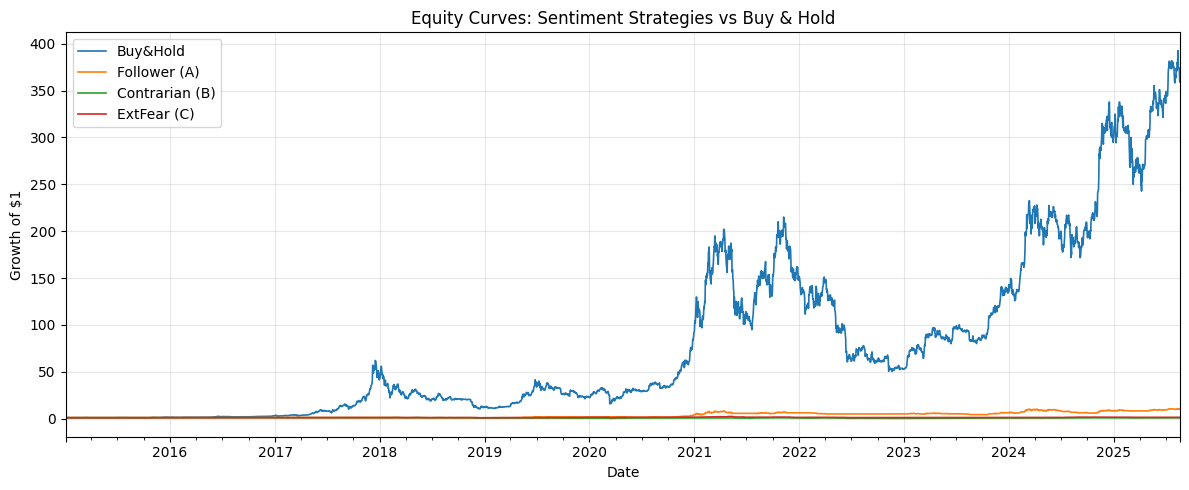

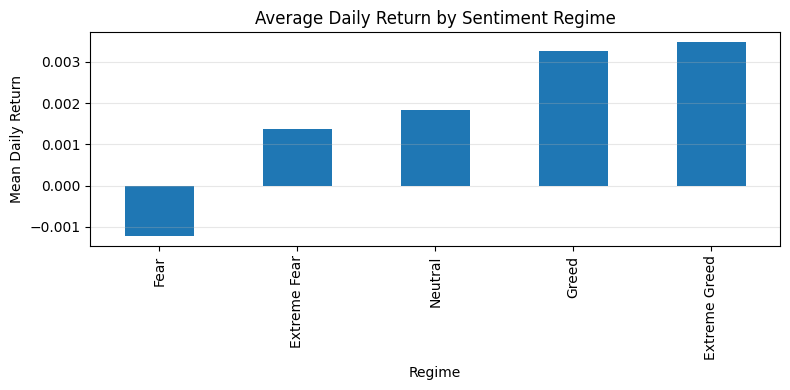

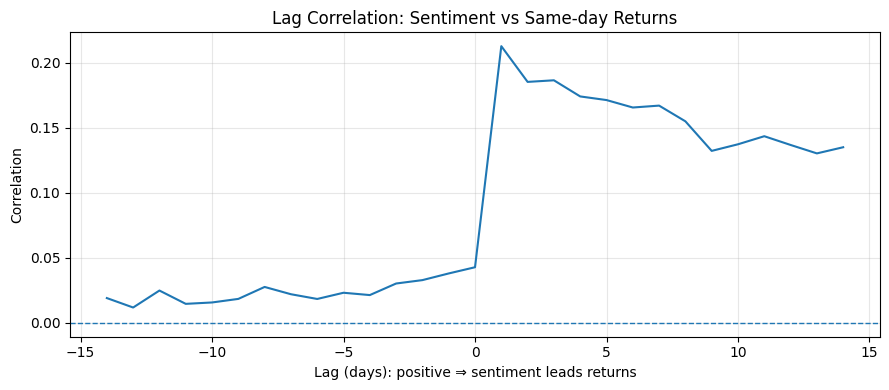

In [16]:

if MAX_PLOTS:
    # Equity curves
    eq = pd.DataFrame(index=perf.index)
    eq['Buy&Hold'] = (1 + perf['BH_ret_net']).cumprod()
    eq['Follower (A)'] = (1 + perf['A_pos_ret_net']).cumprod()
    eq['Contrarian (B)'] = (1 + perf['B_pos_ret_net']).cumprod()
    eq['ExtFear (C)'] = (1 + perf['C_pos_ret_net']).cumprod()

    plt.figure(figsize=(12, 5))
    eq.plot(ax=plt.gca(), linewidth=1.2)
    plt.title('Equity Curves: Sentiment Strategies vs Buy & Hold')
    plt.ylabel('Growth of $1')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Conditional returns bar chart
    plt.figure(figsize=(8, 4))
    cond_returns.plot(kind='bar', ax=plt.gca())
    plt.title('Average Daily Return by Sentiment Regime')
    plt.ylabel('Mean Daily Return')
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Lag correlation plot
    plt.figure(figsize=(9, 4))
    plt.plot(lag_df['lag_days'], lag_df['corr'])
    plt.axhline(0, linestyle='--', linewidth=1)
    plt.title('Lag Correlation: Sentiment vs Same-day Returns')
    plt.xlabel('Lag (days): positive ⇒ sentiment leads returns')
    plt.ylabel('Correlation')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [18]:
# Save plots as high-quality images in the output directory
import os

# Ensure output directory exists
output_dir = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'output')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Re-create plots with high DPI for better quality
# 1. Equity Curve
plt.figure(figsize=(12, 6))
eq.plot(ax=plt.gca(), linewidth=1.5)
plt.title('Equity Curves: Sentiment Strategies vs Buy & Hold', fontsize=14)
plt.ylabel('Growth of $1', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'EquityCurve_highres.png'), dpi=300, bbox_inches='tight')
plt.close()

# 2. Conditional Returns
plt.figure(figsize=(10, 5))
cond_returns.plot(kind='bar', ax=plt.gca())
plt.title('Average Daily Return by Sentiment Regime', fontsize=14)
plt.ylabel('Mean Daily Return', fontsize=12)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'ConditionalReturns_highres.png'), dpi=300, bbox_inches='tight')
plt.close()

# 3. Lag Correlation
plt.figure(figsize=(10, 5))
plt.plot(lag_df['lag_days'], lag_df['corr'], linewidth=2)
plt.axhline(0, linestyle='--', linewidth=1, color='gray')
plt.title('Lag Correlation: Sentiment vs Returns', fontsize=14)
plt.xlabel('Lag (days): positive ⇒ sentiment leads returns', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'LagCorrelation_highres.png'), dpi=300, bbox_inches='tight')
plt.close()

print("High-resolution plots saved to output directory:")

High-resolution plots saved to output directory:


In [2]:
# Export the notebook as HTML for easy sharing
import os
import subprocess

# Define the output directory
output_dir = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'output')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the output path
output_html_path = os.path.join(output_dir, 'Bitcoin_Fear_Greed_Analysis.html')

# Use nbconvert to convert notebook to HTML
try:
    import nbformat
    from nbconvert import HTMLExporter
    
    # Read the notebook
    with open('Notebook_1.ipynb', 'r', encoding='utf-8') as f:
        nb = nbformat.read(f, as_version=4)
    
    # Configure the HTML exporter
    html_exporter = HTMLExporter()
    html_exporter.template_name = 'classic'  # Use the classic template
    
    # Export to HTML
    (html_output, resources) = html_exporter.from_notebook_node(nb)
    
    # Write HTML to file
    with open(output_html_path, 'w', encoding='utf-8') as f:
        f.write(html_output)
    
    print(f"Notebook exported as HTML: {output_html_path}")
    
except ImportError:
    print("nbconvert not installed. Installing and trying again...")
    
    # Alternate method using command line
    try:
        cmd = f"jupyter nbconvert --to html --output-dir=\"{output_dir}\" --output=\"Bitcoin_Fear_Greed_Analysis.html\" Notebook_1.ipynb"
        subprocess.run(cmd, shell=True, check=True)
        print(f"Notebook exported as HTML: {output_html_path}")
    except Exception as e:
        print(f"Failed to export notebook: {e}")

Notebook exported as HTML: c:\Users\Khush\OneDrive\Documents\ds_khushbooKumari\output\Bitcoin_Fear_Greed_Analysis.html


8) EXPORTS

In [2]:
# Create an output directory if it doesn't exist
import os

output_dir = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'output')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print(f"Output directory: {output_dir}")

Output directory: c:\Users\Khush\OneDrive\Documents\ds_khushbooKumari\output


In [17]:
# Save output files to the output directory
import os

# Define the output directory
output_dir = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'output')

# Create panel dataframe from the price and sentiment data
panel = pd.merge_asof(
    px[['Date', 'Close', 'Ret']],
    df[['Date', 'SentimentIndex', 'Regime']],
    on='Date'
)

# Define output files
output_files = [
    'strategy_performance_summary.csv',
    'conditional_returns_by_regime.csv',
    'lag_correlation_sentiment_vs_returns.csv',
    'panel_sentiment_price.csv'
]

# Save each file to the output directory
panel.to_csv(os.path.join(output_dir, 'panel_sentiment_price.csv'), index=False)
stats_df.to_csv(os.path.join(output_dir, 'strategy_performance_summary.csv'), index=False)
cond_returns.to_csv(os.path.join(output_dir, 'conditional_returns_by_regime.csv'))
lag_df.to_csv(os.path.join(output_dir, 'lag_correlation_sentiment_vs_returns.csv'), index=False)

print("Saved files to output directory:")
for file in output_files:
    file_path = os.path.join(output_dir, file)
    print(f"- {file_path}")

Saved files to output directory:
- c:\Users\Khush\OneDrive\Documents\ds_khushbooKumari\output\strategy_performance_summary.csv
- c:\Users\Khush\OneDrive\Documents\ds_khushbooKumari\output\conditional_returns_by_regime.csv
- c:\Users\Khush\OneDrive\Documents\ds_khushbooKumari\output\lag_correlation_sentiment_vs_returns.csv
- c:\Users\Khush\OneDrive\Documents\ds_khushbooKumari\output\panel_sentiment_price.csv


# Save Your Work

To save this notebook to your Google Drive:

1. Click on `File` > `Save a copy in Drive`
2. This will create a copy of the notebook in your Google Drive

Alternatively, to download the notebook to your local machine:

1. Click on `File` > `Download` > `Download .ipynb`